In [1]:
import lmfit
import matplotlib.pyplot as plt
import pystan
import emcee
from scipy.optimize import curve_fit
from lmfit import Model
import matplotlib
import numpy as np

In [198]:
%matplotlib inline
def intrinsic_func(x,mu,dt):
    return mu*np.sin(x+dt)/np.sqrt(x+dt)

x=np.random.rand(200)*10;x=np.sort(x)
sigfx=0.2+np.random.rand(len(x))
print(np.amin(x), np.amax(x))


0.058813326674740374 9.898763059398782


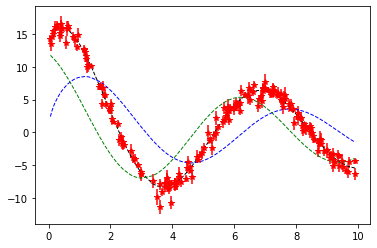

In [199]:
#mu and dt for the images
mu_l=[10.0,15.0,3.5,9.0]
dt_l=[0.0,1.57,0.5,-1.57]
#for simplicity just consider the 1st NI images for now
NI=2;  
fx=np.zeros((NI,len(x)))
for i in np.arange(NI): 
    fx[i]=intrinsic_func(x,mu_l[i],dt_l[i])
    
fx_total=np.sum(fx,axis=0)

y=np.random.normal(fx_total, sigfx)

plt.errorbar(x,y,yerr=sigfx,fmt='r*')
plt.plot(x,fx_total,c='k',lw=1.0,ls="--")
clr=["b","g","c"]
for i in range(NI):
    plt.plot(x,fx[i],c=clr[i],lw=1.0,ls="--")

plt.show()

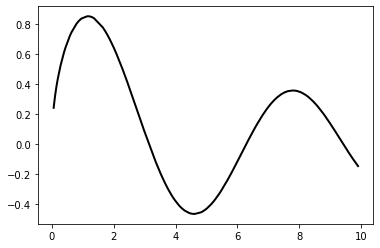

In [200]:
plt.plot(x,intrinsic_func(x,1.0,0),c='k',lw=2.0)

In [201]:
#with lmfit minimization
p = lmfit.Parameters()
p.add_many(('mu1', 2.0, True, 1.0,20.0),('mu2', 2.0,True, 1.0,20.0))
p.add('dt1', value=0.50, min=0.0, max=2.0)
def residual(p):
    v = p.valuesdict()
    return (v['mu1']*np.sin(x)/np.sqrt(x)+v['mu2']*np.sin(x+v['dt1'])/np.sqrt(x+v['dt1']) - y)/sigfx

print(p)
mi = lmfit.minimize(residual, p, method='leastsq', nan_policy='omit');
lmfit.printfuncs.report_fit(mi.params, min_correl=0.5)
print(mi)
#p.add('__lnsigma', value=np.log(0.1), min=np.log(0.001), max=np.log(2))

#res = lmfit.minimize(residual, method='emcee', nan_policy='omit', burn=300, steps=1000, thin=7, nwalkers=200,
#                     params=mi.params, is_weighted=False)
#lmfit.report_fit(res.params)

Parameters([('mu1', <Parameter 'mu1', 2.0, bounds=[1.0:20.0]>), ('mu2', <Parameter 'mu2', 2.0, bounds=[1.0:20.0]>), ('dt1', <Parameter 'dt1', 0.5, bounds=[0.0:2.0]>)])
[[Variables]]
    mu1:  9.82030024 +/- 0.70742801 (7.20%) (init = 2)
    mu2:  14.9519022 +/- 0.12746917 (0.85%) (init = 2)
    dt1:  1.55509108 +/- 0.06114126 (3.93%) (init = 0.5)
[[Correlations]] (unreported correlations are < 0.500)
    C(mu1, dt1) =  0.992


In [202]:
#with lmfit emcee
p = lmfit.Parameters()

p.add_many(('mu1', 2.0, True, 1.0,20.0),('mu2', 2.0,True, 1.0,20.0))
p.add('dt1', value=0.50, min=0.0, max=2.0)
print(p)
def residual(p):
    v = p.valuesdict()
    return (v['mu1']*np.sin(x)/np.sqrt(x)+v['mu2']*np.sin(x+v['dt1'])/np.sqrt(x+v['dt1']) - y)/sigfx

print(p)
p.add('__lnsigma', value=np.log(0.1), min=np.log(0.001), max=np.log(2))

res = lmfit.minimize(residual, method='emcee', nan_policy='omit', burn=300, steps=1000, thin=7, nwalkers=50,
                     params=p, is_weighted=False)
lmfit.report_fit(res.params)

  1%|          | 11/1000 [00:00<00:09, 109.53it/s]

Parameters([('mu1', <Parameter 'mu1', 2.0, bounds=[1.0:20.0]>), ('mu2', <Parameter 'mu2', 2.0, bounds=[1.0:20.0]>), ('dt1', <Parameter 'dt1', 0.5, bounds=[0.0:2.0]>)])
Parameters([('mu1', <Parameter 'mu1', 2.0, bounds=[1.0:20.0]>), ('mu2', <Parameter 'mu2', 2.0, bounds=[1.0:20.0]>), ('dt1', <Parameter 'dt1', 0.5, bounds=[0.0:2.0]>)])


100%|██████████| 1000/1000 [00:06<00:00, 156.07it/s]

[[Variables]]
    mu1:        9.84556491 +/- 0.69313660 (7.04%) (init = 2)
    mu2:        14.9774223 +/- 0.13326830 (0.89%) (init = 2)
    dt1:        1.55652606 +/- 0.05987015 (3.85%) (init = 0.5)
    __lnsigma:  0.02565085 +/- 0.05096750 (198.70%) (init = -2.302585)
[[Correlations]] (unreported correlations are < 0.100)
    C(mu1, dt1) =  0.992
    C(mu2, dt1) =  0.146
    C(mu1, mu2) =  0.110


odict_values([9.845564906489244, 14.977422332545173, 1.556526055877403, 0.02565084931294687])


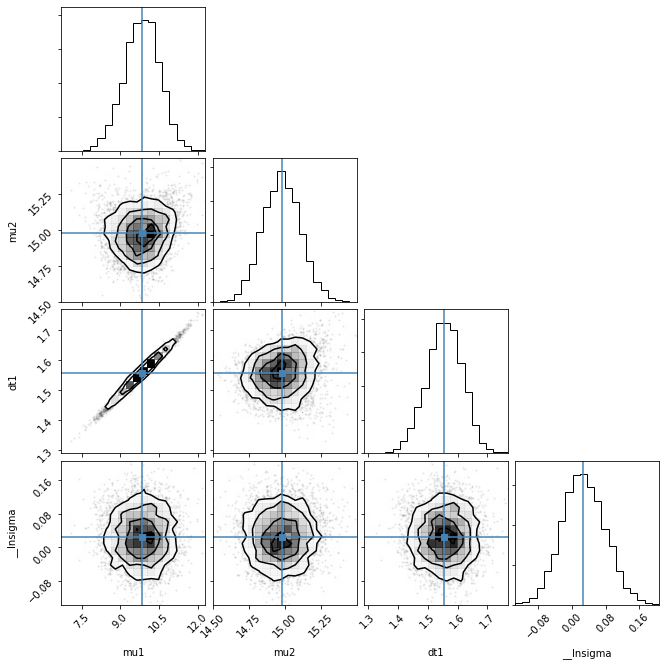

In [203]:
import corner
print(res.params.valuesdict().values())
emcee_plot = corner.corner(res.flatchain, labels=res.var_names,
                           truths=list(res.params.valuesdict().values()))

In [204]:
#using mcmc

def log_likelihood(theta, x, y, yerr): 
    mu0,mu1,dt1 = theta;
    mu=np.zeros(2); dt=np.zeros(2); mu[0]=mu0; mu[1]=mu1; dt[0]=0; dt[1]=dt1;
    dp=len(x);
    fxx=np.zeros((NI,dp))
    for i in np.arange(NI):
        fxx[i]=mu[i]*np.sin(x+dt[i])/np.sqrt(x+dt[i])#/np.power(x,pr)
        
    model =np.sum(fxx,axis=0) #mu*np.sin(x)/np.power(x,pr)
    sigma2 = yerr**2;#yerr ** 2 + model ** 2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 /sigma2)

def log_prior(theta):
    mu0,mu1,dt1 = theta;
    mu=np.zeros(2); dt=np.zeros(2); mu[0]=mu0; mu[1]=mu1; dt[0]=0; dt[1]=dt1;
    if 1.0 < mu[0] < 20.0 and 1.0 < mu[1] < 20.0 and 0 < dt1 <2:# and 0.0 < pr < 2.0:# and -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

import emcee

p0=np.array([2.0,2.0,0.5]);
Npar=len(p0); Nwalker=200
pos = p0 + 1e-4 * np.random.randn(Nwalker, Npar)
nwalkers, ndim = (Nwalker, Npar)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, sigfx))
xxx1=sampler.run_mcmc(pos,2000);

In [205]:
flat_samples = sampler.get_chain(discard=200, thin=7, flat=True)
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [2.5,16,25, 50,75, 84,97.5])
    print(mcmc)

[ 8.37101073  9.09127541  9.31720847  9.79958054 10.25736889 10.47394696
 11.08816123]
[14.7275366  14.84772555 14.88805252 14.97208802 15.05773506 15.10034403
 15.2264828 ]
[1.43160513 1.49251219 1.51185142 1.55329859 1.59305985 1.61199268
 1.66516747]


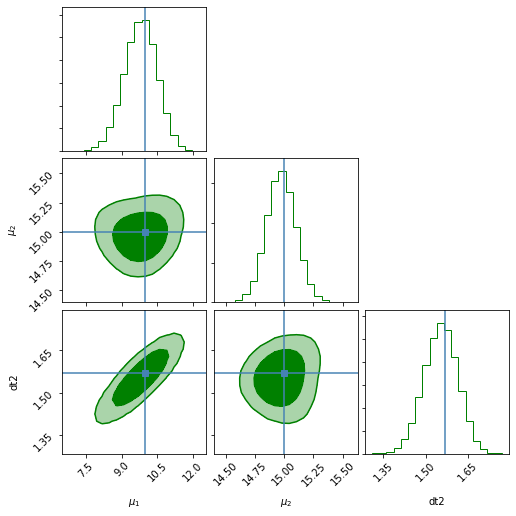

In [206]:
import corner
samples1 = sampler.chain[:, 300:, ].reshape((-1, 3))
fig1 = corner.corner(samples1, labels=[r"$\mu_1$",r"$\mu_2$","dt2"],
                        color='g', smooth=1,
                        levels=(0.68,0.95), plot_density=0, fill_contours=1, plot_datapoints=0, truths=[mu_l[0],mu_l[1], dt_l[1]])

In [207]:
#pystan: assuming the model=mu*sin(t+dt)/np.sqrt(t); setting dt1=0;
model = """
data {
    int<lower=0> N;
    int<lower=0> ni;
    vector[N] x;
    vector[N] y;
    vector[N] yerror;
}
parameters {
    real<lower=1.0, upper=20> mu [ni];
    real <lower=0, upper=2> dt[ni-1];
    //real sig;
    
}
model {
    real dum;
    real dtt;
    for(i in 1:N) {
        dum=0;
        for (j in 1:ni){
            if(j==1){dtt=0;}
            else {dtt=dt[j-1];}
            dum=dum+mu[j]*sin(x[i]+dtt)/sqrt(x[i]+dtt);
        }
        //y[i] ~ normal(dum, yerror[i]);
        target+=normal_lpdf(y[i]|dum,yerror[i]);
    }
}
"""
# Put our data in a dictionary
data = {'N': len(x),'ni':NI, 'x': x, 'y': y, 'yerror':sigfx}

# Compile the model
sm = pystan.StanModel(model_code=model)

# Train the model and generate samples
fit = sm.sampling(data=data, iter=2000, chains=4, warmup=400, thin=3, seed=101)
print(fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_867b507332cc9a6487548917033e882a NOW.


Inference for Stan model: anon_model_867b507332cc9a6487548917033e882a.
4 chains, each with iter=2000; warmup=400; thin=3; 
post-warmup draws per chain=534, total post-warmup draws=2136.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[1]   9.79    0.02   0.71   8.37   9.32   9.81  10.28  11.09    993    1.0
mu[2]  14.97  3.1e-3   0.13  14.74  14.89  14.97  15.06  15.22   1600    1.0
dt[1]   1.55  1.9e-3   0.06   1.43   1.51   1.55   1.59   1.67   1017    1.0
lp__  -200.7    0.03   1.21 -203.9 -201.2 -200.4 -199.8 -199.3   1487    1.0

Samples were drawn using NUTS at Mon Nov 18 19:32:36 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [213]:
#pystan: modelling the intrinsic function with 9 parameters and interpolation
model = """
data {
    int<lower=0> N;
    int<lower=0> ni;
    int<lower=5> NP;
    vector[N] x;
    vector[N] y;
    vector[N] yerror;
}
parameters {
    real<lower=1.0, upper=20> mu [ni];
    real <lower=0.0, upper=2.0> dt[ni-1];#for simplicity just consider dt>0
    vector <lower=-1.0, upper=1.0> [NP] P;
    //real sig;
    
}
model {
    real dum;
    real td=0.5;
    real dum_t;
    int ti;
    real dtt;
    
    real mod_intr_f;
    
    for(i in 1:N) {
        dum=0;
        for (j in 1:ni){
            dum_t=x[i];
            if(j==1){dtt=0;}
            else {dtt=dt[j-1];}
            
            dum_t=dum_t+dtt;
            ti=1;
            //because there is no real to int conversion in stan we have to do it in this way
            while(dum_t>ti*td){
                ti=ti+1;
            }
            mod_intr_f=P[ti+1]+((P[ti+1]-P[ti])/td)*(dum_t-ti*td);
            dum+=mu[j]*mod_intr_f;
        }
        //y[i] ~ normal(dum, yerror[i]);
        target+=normal_lpdf(y[i]|dum, yerror[i]);
    }
}
"""
NP=25; # we see that the result is quite sensitive to this.
# Put our data in a dictionary
data = {'N': len(x),'ni':NI,'NP':NP, 'x': x, 'y': y, 'yerror':sigfx}

# Compile the model
sm = pystan.StanModel(model_code=model)

# Train the model and generate samples
fit = sm.sampling(data=data, iter=2000, chains=4, warmup=400, thin=3, seed=101)
print(fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_540aff41cd29fcca430ce00be1507468 NOW.


Inference for Stan model: anon_model_540aff41cd29fcca430ce00be1507468.
4 chains, each with iter=2000; warmup=400; thin=3; 
post-warmup draws per chain=534, total post-warmup draws=2136.

         mean se_mean     sd   2.5%    25%    50%     75%  97.5%  n_eff   Rhat
mu[1]    9.06    0.04   1.38   6.34   8.28   9.01    9.82  11.98    942    1.0
mu[2]    8.75    0.05    1.4   6.02   7.91   8.67    9.52  11.71    655   1.01
dt[1]    0.62    0.05   0.22    0.4   0.49   0.52    0.81   1.13     20   1.21
P[1]     0.73  3.0e-3    0.1   0.51   0.67   0.74    0.79   0.93   1149    1.0
P[2]     0.91  1.9e-3   0.08    0.7   0.87   0.93    0.97    1.0   1688    1.0
P[3]     0.91  4.2e-3   0.08    0.7   0.87   0.93    0.97    1.0    369   1.02
P[4]     0.69    0.02   0.13   0.48    0.6   0.66    0.75   0.98     31   1.11
P[5]     0.42    0.03   0.14   0.25   0.34   0.38    0.46   0.78     26   1.14
P[6]     0.02    0.01    0.1  -0.14  -0.05   0.02    0.08   0.22     72   1.06
P[7]    -0.26  3.0e-3  

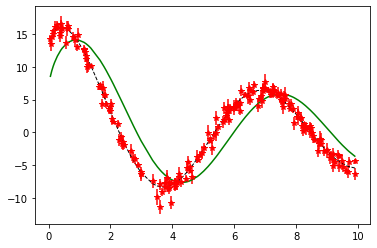

In [210]:
M=[9.19,8.14]
dt=0.66

ffx=intrinsic_func(x,M[0],0)+intrinsic_func(x,M[1],dt)
plt.errorbar(x,y,yerr=sigfx,fmt='r*')
plt.plot(x,fx_total,c='k',lw=1.0,ls="--")
plt.plot(x,ffx,c="g")